Use Python to fetch country debt profiles. Use a horizontal bar chart, the y-axis is the list of all countries in the world (for example, Japan, Korea, Philippines, China, and more), and the x-axis is the total debt in $.  Make a ranking label on the outside and the right part of the bar, followed by the number of debt$ label

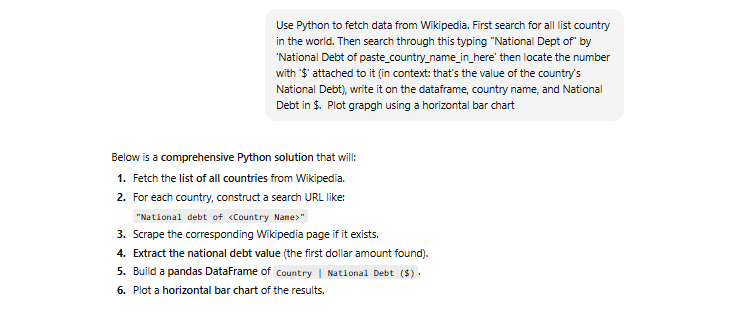